<a href="https://colab.research.google.com/github/Talendar/stocks_prices_prediction/blob/main/multi_stocks_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prediction of Stocks Prices with Deep Learning**

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display, Javascript
from google.colab import files

import os
import shutil
from datetime import datetime

!pip install tensorflow==2.4.0-rc4
import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
tf.keras.backend.set_floatx('float64')

!pip install scikit-learn==0.24.0rc1

!pip install yahooquery
from yahooquery import Ticker

!rm -rf stocks
!git clone https://github.com/Talendar/stocks_prices_prediction stocks

%load_ext autoreload
%autoreload 2

from stocks.aux.stocks_data import MultiStocksDataset
from stocks.aux.eval import *
from stocks.aux.normalization import *
from stocks.aux.tf_callbacks import ClearCallback
Javascript("google.colab.output.setIframeHeight('250px');")

## **0) Base settings**

In [16]:
NUM_SESSIONS = 10  # number of previous trading sessions the model will analyse in order to make a prediction
NORMALIZE_LABELS = True

TRAIN_PC, VAL_PC, TEST_PC = 0.8, 0.12, 0.08
assert (TRAIN_PC + VAL_PC + TEST_PC) == 1

LABELS_NAMES = [    # values that the model will try to predict
    "open", "low", "high",
]

INTERVAL = "1d"
NAME_LIST = set([
    "^BVSP",                                        # Brazil
    "^DJI", "^GSPC", "^IXIC", "^NYA",               # US
    "^FTSE", "^FCHI", "^GDAXI", "^IBEX", "^AEX",    # Europe
    "000001.SS", "^HSI",                            # China
    "^N225",                                        # Japan
    "^GSPTSE",                                      # Canada
    "^MXX",                                         # Mexico
    "^AXJO",                                        # Australia
])

# loading stocks with specific params:
STOCKS = {
}

# loading stocks from NAME_LIST with default info (same params for all):
STOCKS.update({name: {"start": "2007-01-01",
                      "end": "2020-12-08",
                      "period": None} \
               for name in NAME_LIST})

## **1) Preparing the data**

#### **1.1) Fetching and pre-processing the data**

In [17]:
multi_data = {
    name: Ticker(name).history(start=info["start"],
                               end=info["end"],
                               period=info["period"], 
                               interval=INTERVAL).reset_index("symbol", drop=True) \
    for name, info in STOCKS.items()
}

multi_data = MultiStocksDataset(
    stocks=multi_data, 
    num_sessions=NUM_SESSIONS,
    labels_names=LABELS_NAMES,
    batch_size=len(STOCKS) * 5,
    data_split_pc=(TRAIN_PC, VAL_PC, TEST_PC),
    feature_normalization=(min_max_norm, min_max_denorm), 
    label_normalization=(min_max_norm, min_max_denorm) \
                        if NORMALIZE_LABELS else None,
)

#### **1.2) Inspecting the data**



###################################   ^IXIC   ###################################

. Period: from 2007-01-03 to 2020-12-07
. Trading sessions: 3508
. Data:



,high,volume,close,open,low
date,,,,,
2007-01-03,2454.620117,2435280000,2423.159912,2429.719971,2394.659912
2007-01-04,2460.510010,2104210000,2453.429932,2423.820068,2413.750000
2007-01-05,2445.070068,2060360000,2434.250000,2445.070068,2420.590088
2007-01-08,2445.629883,1905620000,2438.199951,2435.250000,2421.129883
2007-01-09,2449.870117,2144160000,2443.830078,2443.260010,2423.560059
...,...,...,...,...,...
2020-12-01,12405.790039,6467180000,12355.110352,12313.360352,12263.929688
2020-12-02,12360.059570,5150820000,12349.370117,12285.750000,12217.349609
2020-12-03,12439.019531,5182100000,12377.179688,12369.259766,12356.990234



. Statistics:



,high,volume,close,open,low
count,3508.000000,3.508000e+03,3508.000000,3508.000000,3508.000000
mean,4577.073657,2.137794e+09,4549.848133,4548.891445,4517.866491
std,2449.162432,6.660341e+08,2434.667259,2433.940049,2417.155135
min,1316.150024,1.494100e+08,1268.640015,1284.839966,1265.520020
25%,2570.992554,1.777898e+09,2554.312500,2555.802429,2535.134949
50%,4066.150024,1.988540e+09,4045.005005,4041.214966,4021.585083
75%,6218.502441,2.270200e+09,6193.697388,6203.107544,6150.790039
max,12536.230469,7.693430e+09,12519.950195,12461.000000,12460.549805



. Plot:



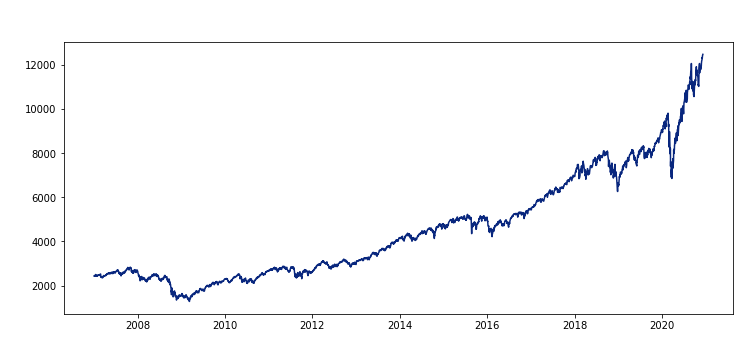



################################################################################




###################################   ^FTSE   ###################################

. Period: from 2007-01-02 to 2020-12-07
. Trading sessions: 3511
. Data:



,close,volume,high,open,low
date,,,,,
2007-01-02,6310.899902,1.074946e+09,6312.500000,6220.799805,6220.799805
2007-01-03,6319.000000,1.606893e+09,6322.000000,6310.899902,6296.000000
2007-01-04,6287.000000,1.902876e+09,6319.000000,6319.000000,6261.000000
2007-01-05,6220.100098,1.622439e+09,6287.000000,6287.000000,6220.100098
2007-01-08,6194.200195,1.326701e+09,6246.000000,6220.100098,6187.000000
...,...,...,...,...,...
2020-12-01,6384.700195,8.398583e+08,6400.200195,6266.200195,6263.600098
2020-12-02,6463.399902,9.368428e+08,6468.600098,6384.700195,6367.500000
2020-12-03,6490.299805,9.432145e+08,6491.500000,6463.399902,6430.299805



. Statistics:



,close,volume,high,open,low
count,3511.000000,3.511000e+03,3511.000000,3511.000000,3511.000000
mean,6267.233408,9.436311e+08,6309.162606,6267.175618,6223.639992
std,873.454391,3.936803e+08,865.302028,873.435789,882.630251
min,3512.100098,6.676710e+07,3564.800049,3512.100098,3460.699951
25%,5752.100098,6.825844e+08,5790.149902,5752.100098,5707.400146
50%,6331.799805,8.236307e+08,6367.799805,6330.500000,6280.100098
75%,6887.850098,1.087422e+09,6917.650146,6887.850098,6848.350098
max,7877.500000,3.761301e+09,7903.500000,7877.500000,7854.600098



. Plot:



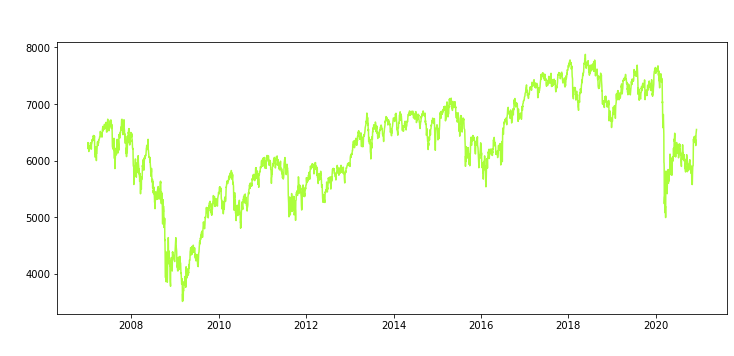



################################################################################




###################################   000001.SS   ###################################

. Period: from 2007-01-04 to 2020-12-07
. Trading sessions: 3386
. Data:



,low,volume,close,open,high
date,,,,,
2007-01-04,2684.818115,120200.0,2715.718994,2728.187988,2847.614990
2007-01-05,2617.019043,106200.0,2641.333984,2668.576904,2685.803955
2007-01-08,2620.625000,106800.0,2707.198975,2621.068115,2708.444092
2007-01-09,2691.360107,110800.0,2807.803955,2711.049072,2809.394043
2007-01-10,2770.988037,111800.0,2825.575928,2838.113037,2841.740967
...,...,...,...,...,...
2020-12-01,3386.909912,316200.0,3451.939941,3388.989990,3457.639893
2020-12-02,3435.871094,312800.0,3449.381104,3453.518066,3465.729004
2020-12-03,3428.803955,298500.0,3442.135986,3448.540039,3452.160889



. Statistics:



,low,volume,close,open,high
count,3386.000000,3386.000000,3386.000000,3386.000000,3386.000000
mean,2905.793293,162625.605434,2937.169381,2934.095658,2961.474541
std,696.334532,115893.442386,710.476332,710.587408,720.577433
min,1664.925049,0.000000,1706.703003,1671.395996,1717.100952
25%,2383.465515,88400.000000,2408.159302,2406.137756,2421.925171
50%,2879.650513,131800.000000,2906.251953,2904.775513,2927.008057
75%,3199.374817,193500.000000,3223.995544,3224.252991,3250.764465
max,6040.712891,857100.000000,6092.057129,6057.428223,6124.043945



. Plot:



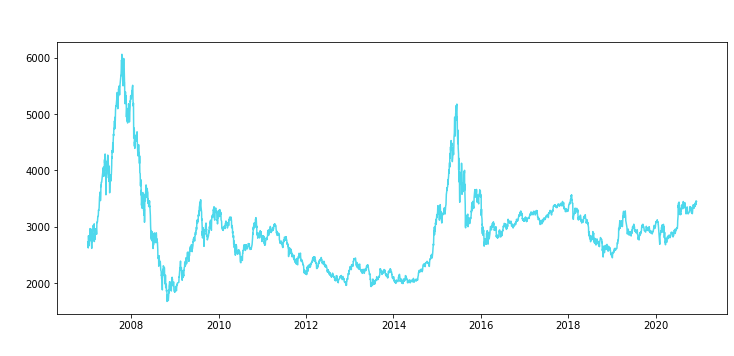



################################################################################




###################################   ^N225   ###################################

. Period: from 2007-01-04 to 2020-12-08
. Trading sessions: 3404
. Data:



,close,volume,high,open,low
date,,,,,
2007-01-04,17353.669922,80100.0,17379.460938,17322.500000,17315.759766
2007-01-05,17091.589844,158600.0,17327.130859,17315.539062,17011.099609
2007-01-09,17237.769531,142400.0,17261.029297,17018.890625,16983.970703
2007-01-10,16942.400391,133500.0,17199.419922,17192.419922,16847.570312
2007-01-11,16838.169922,121900.0,17057.449219,16958.570312,16758.460938
...,...,...,...,...,...
2020-12-02,26800.980469,80200.0,26889.900391,26884.990234,26695.279297
2020-12-03,26809.369141,69500.0,26868.089844,26740.300781,26719.230469
2020-12-04,26751.240234,61600.0,26799.830078,26697.259766,26646.080078



. Statistics:



,close,volume,high,open,low
count,3404.000000,3404.000000,3404.000000,3404.000000,3404.000000
mean,15596.231734,130463.895417,15688.987110,15598.865763,15500.247325
std,5011.910772,52782.598861,5023.118341,5009.701462,4994.682542
min,7054.979980,0.000000,7100.770020,7059.770020,6994.899902
25%,10234.902344,97175.000000,10292.082275,10255.720459,10183.159912
50%,15847.680176,127100.000000,15960.805176,15850.299805,15738.535156
75%,19956.359375,154825.000000,20025.545410,19968.093262,19897.271973
max,26809.369141,595200.000000,26894.250000,26894.250000,26719.230469



. Plot:



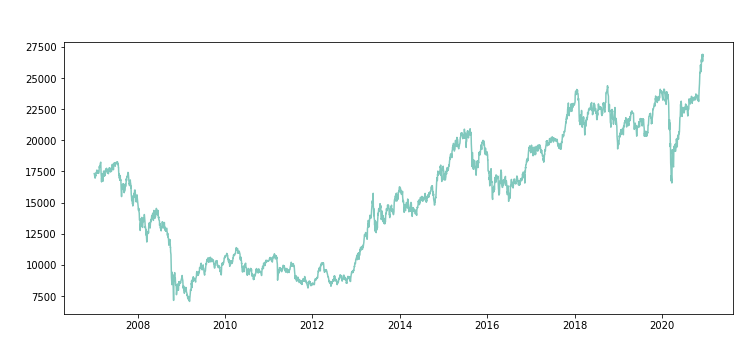



################################################################################




###################################   ^MXX   ###################################

. Period: from 2007-01-02 to 2020-12-07
. Trading sessions: 3489
. Data:



,volume,low,close,open,high
date,,,,,
2007-01-02,37688400.0,26448.320312,26664.449219,26448.320312,26666.919922
2007-01-03,134658000.0,26319.500000,26619.369141,26666.839844,26699.099609
2007-01-04,103649000.0,26335.419922,26566.279297,26622.109375,26623.060547
2007-01-05,105575400.0,26112.769531,26135.599609,26566.279297,26566.279297
2007-01-08,122179800.0,26071.660156,26281.640625,26135.599609,26282.390625
...,...,...,...,...,...
2020-12-01,224469600.0,41902.769531,42895.628906,41987.429688,43204.101562
2020-12-02,174294200.0,42956.730469,43674.828125,43010.480469,43730.960938
2020-12-03,175436600.0,43477.660156,43934.210938,43512.269531,44013.109375



. Statistics:



,volume,low,close,open,high
count,3.489000e+03,3489.000000,3489.000000,3489.000000,3489.000000
mean,1.845977e+08,38505.092997,38774.117235,38772.636587,39027.948048
std,9.061487e+07,7690.366310,7677.208003,7679.970295,7665.667083
min,0.000000e+00,16480.009766,16891.029297,16867.390625,17203.449219
25%,1.367115e+08,32429.669922,32679.359375,32666.160156,32809.558594
50%,1.701641e+08,40401.078125,40711.558594,40706.441406,40958.648438
75%,2.153290e+08,44338.519531,44597.320312,44593.890625,44844.738281
max,1.759968e+09,51524.230469,51713.378906,51590.480469,51772.371094



. Plot:



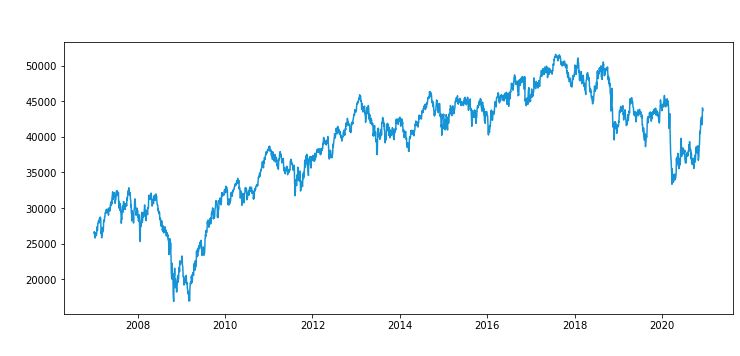



################################################################################




###################################   ^GDAXI   ###################################

. Period: from 2007-01-02 to 2020-12-07
. Trading sessions: 3530
. Data:



,volume,low,close,open,high
date,,,,,
2007-01-02,70947800.0,6614.729980,6681.129883,6614.729980,6682.810059
2007-01-03,105913800.0,6667.580078,6691.319824,6681.229980,6704.040039
2007-01-04,143461600.0,6634.740234,6674.399902,6662.240234,6684.109863
2007-01-05,142562500.0,6588.029785,6593.089844,6661.899902,6665.509766
2007-01-08,116670200.0,6579.899902,6607.589844,6603.549805,6628.359863
...,...,...,...,...,...
2020-12-01,66675500.0,13334.990234,13382.299805,13371.660156,13434.299805
2020-12-02,63822100.0,13272.469727,13313.240234,13341.910156,13359.269531
2020-12-03,64310300.0,13223.929688,13252.860352,13304.830078,13307.540039



. Statistics:



,volume,low,close,open,high
count,3.530000e+03,3530.000000,3530.000000,3530.000000,3530.000000
mean,1.152738e+08,8937.903796,9005.275302,9006.391127,9068.592041
std,5.485129e+07,2654.731870,2659.779823,2660.150769,2665.546241
min,0.000000e+00,3588.889893,3666.409912,3677.070068,3706.320068
25%,8.103605e+07,6664.679810,6724.060059,6724.612671,6774.742554
50%,1.039062e+08,8971.824707,9017.540039,9032.479980,9076.224609
75%,1.374964e+08,11484.594727,11549.830078,11560.134766,11616.982666
max,4.940122e+08,13754.040039,13789.000000,13774.440430,13795.240234



. Plot:



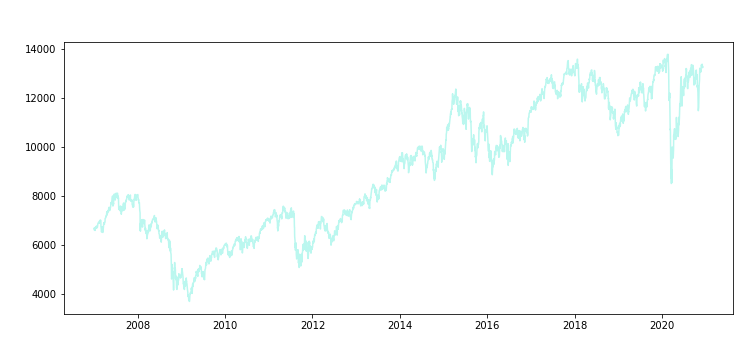



################################################################################




###################################   ^HSI   ###################################

. Period: from 2007-01-02 to 2020-12-07
. Trading sessions: 3427
. Data:



,volume,open,low,close,high
date,,,,,
2007-01-02,1.264597e+09,20004.839844,19990.279297,20310.179688,20323.589844
2007-01-03,1.673969e+09,20353.419922,20249.609375,20413.390625,20554.580078
2007-01-04,2.130510e+09,20415.669922,19948.019531,20025.580078,20463.179688
2007-01-05,1.959114e+09,19890.150391,19757.240234,20211.279297,20213.640625
2007-01-08,1.438589e+09,19915.000000,19844.310547,20029.660156,20085.580078
...,...,...,...,...,...
2020-12-01,3.564239e+09,26422.710938,26375.240234,26567.679688,26662.179688
2020-12-02,3.704087e+09,26670.119141,26379.480469,26532.580078,26670.119141
2020-12-03,2.830414e+09,26623.419922,26556.019531,26728.500000,26781.990234



. Statistics:



,volume,open,low,close,high
count,3.427000e+03,3427.000000,3427.000000,3427.000000,3427.000000
mean,1.863009e+09,23212.719056,23041.040749,23198.626879,23350.846413
std,7.516274e+08,3651.274005,3645.161908,3646.940054,3650.488356
min,0.000000e+00,11154.570312,10676.290039,11015.839844,11747.110352
25%,1.394401e+09,20960.765625,20816.569336,20937.269531,21056.660156
50%,1.704109e+09,23026.179688,22872.330078,23012.369141,23143.880859
75%,2.133427e+09,25498.879883,25268.724609,25478.385742,25652.370117
max,9.799120e+09,33335.480469,32897.039062,33154.121094,33484.078125



. Plot:



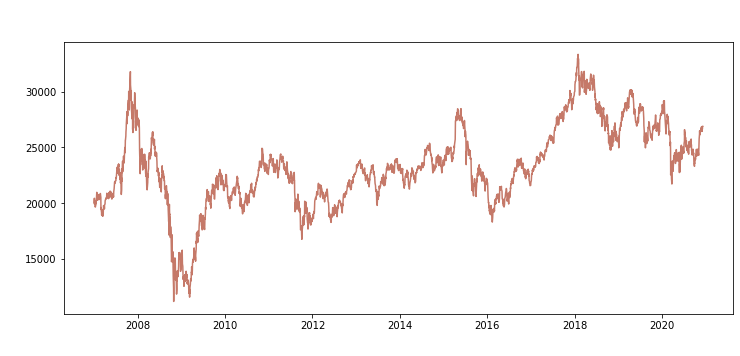



################################################################################




###################################   ^AEX   ###################################

. Period: from 2007-01-02 to 2020-12-07
. Trading sessions: 3564
. Data:



,high,volume,close,open,low
date,,,,,
2007-01-02,501.390015,68535200,501.000000,497.910004,497.859985
2007-01-03,501.799988,96484400,501.350006,501.480011,499.850006
2007-01-04,500.959991,117535300,500.329987,498.200012,497.929993
2007-01-05,499.209991,125123300,494.049988,498.390015,494.040009
2007-01-08,495.880005,113168100,492.809998,495.369995,491.420013
...,...,...,...,...,...
2020-12-01,613.409973,108100,611.409973,609.000000,607.299988
2020-12-02,612.320007,99300,610.940002,608.760010,607.729980
2020-12-03,613.260010,89300,610.479980,612.429993,608.390015



. Statistics:



,high,volume,close,open,low
count,3564.000000,3.564000e+03,3564.000000,3564.000000,3564.000000
mean,432.720315,1.059102e+08,430.012719,430.110413,427.147438
std,100.347470,4.525575e+07,100.366654,100.305411,100.367838
min,200.740005,0.000000e+00,199.250000,199.339996,194.990005
25%,342.335007,7.882358e+07,340.454994,340.225006,337.975006
50%,436.910004,9.733515e+07,432.870010,433.134995,428.495010
75%,525.290009,1.223952e+08,522.242477,522.852509,519.797485
max,632.119995,5.278209e+08,629.229980,630.559998,627.489990



. Plot:



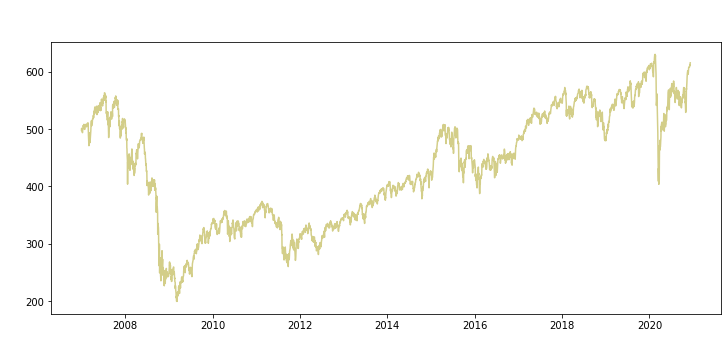



################################################################################




###################################   ^BVSP   ###################################

. Period: from 2007-01-02 to 2020-12-07
. Trading sessions: 3441
. Data:



,close,open,low,volume,high
date,,,,,
2007-01-02,45383.0,44476.0,44476.0,75560200.0,45388.0
2007-01-03,44445.0,45379.0,44284.0,122372800.0,45379.0
2007-01-04,44020.0,44442.0,43623.0,86577000.0,44442.0
2007-01-05,42245.0,44019.0,42160.0,164055000.0,44081.0
2007-01-08,42830.0,42249.0,42144.0,114007100.0,42926.0
...,...,...,...,...,...
2020-12-01,111335.0,108897.0,108897.0,11324800.0,111840.0
2020-12-02,111814.0,111402.0,110579.0,9814300.0,112315.0
2020-12-03,112919.0,111874.0,111874.0,11474200.0,113377.0



. Statistics:



,close,open,low,volume,high
count,3441.000000,3441.00000,3441.000000,3.441000e+03,3441.000000
mean,64588.594885,64568.33159,63899.225516,8.226186e+06,65241.841616
std,17590.489320,17568.05804,17483.078299,2.272670e+07,17668.235175
min,29435.000000,29438.00000,29435.000000,0.000000e+00,31480.000000
25%,52764.000000,52758.00000,52190.000000,2.243600e+06,53312.000000
50%,60452.000000,60416.00000,59815.000000,3.313000e+06,61188.000000
75%,70385.000000,70377.00000,69698.000000,4.578200e+06,70958.000000
max,119528.000000,119528.00000,118108.000000,2.322653e+08,119593.000000



. Plot:



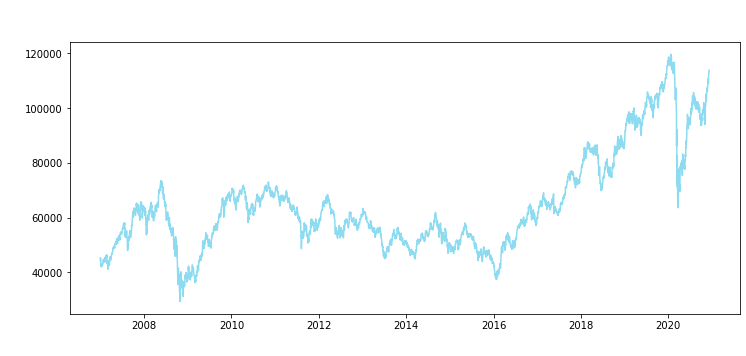



################################################################################




###################################   ^AXJO   ###################################

. Period: from 2007-01-02 to 2020-12-08
. Trading sessions: 3521
. Data:



,close,open,high,volume,low
date,,,,,
2007-01-02,5670.200195,5672.700195,5690.700195,0.0,5670.100098
2007-01-03,5649.399902,5681.700195,5698.200195,0.0,5643.700195
2007-01-04,5584.799805,5634.299805,5635.200195,0.0,5584.799805
2007-01-05,5572.000000,5580.000000,5612.000000,0.0,5565.200195
2007-01-08,5502.000000,5561.100098,5562.600098,0.0,5499.000000
...,...,...,...,...,...
2020-12-02,6590.200195,6588.500000,6616.000000,749000.0,6561.500000
2020-12-03,6615.299805,6590.200195,6628.200195,699400.0,6590.200195
2020-12-04,6634.100098,6615.299805,6650.100098,612100.0,6613.899902



. Statistics:



,close,open,high,volume,low
count,3521.000000,3521.000000,3521.000000,3.521000e+03,3521.000000
mean,5305.108039,5304.950923,5333.890034,6.212907e+07,5274.337262
std,799.486733,798.993875,799.663988,1.900768e+08,799.287555
min,3145.500000,3148.500000,2947.100098,0.000000e+00,3120.800049
25%,4710.700195,4708.100098,4732.399902,0.000000e+00,4686.799805
50%,5368.799805,5372.299805,5395.899902,0.000000e+00,5337.600098
75%,5897.899902,5896.899902,5930.399902,0.000000e+00,5865.899902
max,7162.500000,7162.500000,7197.200195,1.353735e+09,7144.600098



. Plot:



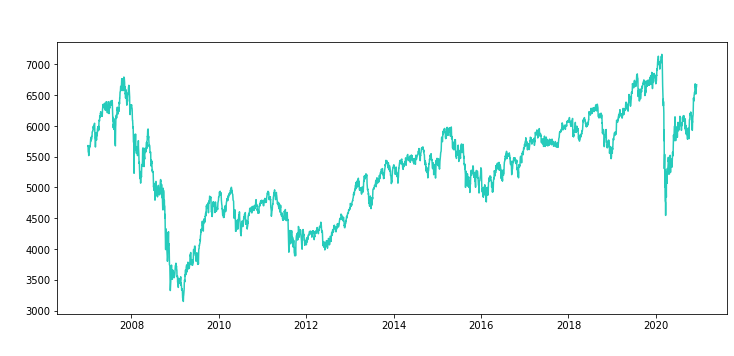



################################################################################




###################################   ^NYA   ###################################

. Period: from 2007-01-03 to 2020-12-07
. Trading sessions: 3508
. Data:



,high,volume,open,low,close
date,,,,,
2007-01-03,9209.299805,3429160000,9137.959961,9092.950195,9133.080078
2007-01-04,9132.250000,0,9132.250000,9070.110352,9113.160156
2007-01-05,9113.160156,2919400000,9113.160156,9002.330078,9025.040039
2007-01-08,9052.099609,2763340000,9025.040039,8993.620117,9041.120117
2007-01-09,9048.269531,3038380000,9041.099609,8984.200195,9023.900391
...,...,...,...,...,...
2020-12-01,14233.459961,5403660000,14183.450195,14131.330078,14146.639648
2020-12-02,14198.790039,5029620000,14104.059570,14076.709961,14188.240234
2020-12-03,14283.730469,5091760000,14210.540039,14184.490234,14217.179688



. Statistics:



,high,volume,open,low,close
count,3508.000000,3.508000e+03,3508.000000,3508.000000,3508.000000
mean,9890.779830,3.979311e+09,9837.355669,9776.581320,9837.302246
std,2183.914597,1.183190e+09,2190.941292,2199.522523,2190.938159
min,4321.759766,0.000000e+00,4226.310059,4181.750000,4226.310059
25%,8164.117432,3.275395e+09,8123.010010,8077.035156,8123.047363
50%,10051.899902,3.720505e+09,10005.115234,9943.334961,10005.830078
75%,11521.532959,4.424832e+09,11481.852783,11419.790283,11465.472412
max,14417.400391,1.145623e+10,14375.549805,14314.469727,14417.330078



. Plot:



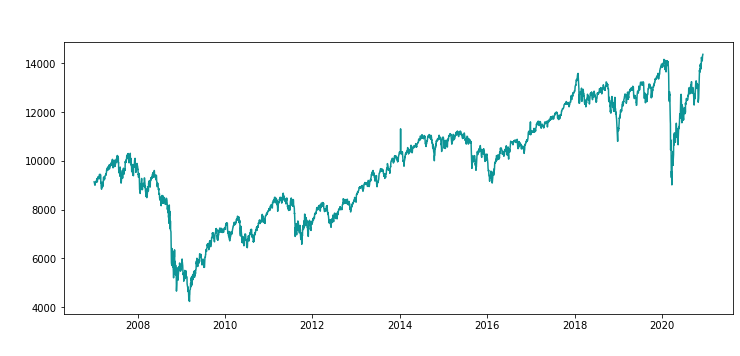



################################################################################




###################################   ^FCHI   ###################################

. Period: from 2007-01-02 to 2020-12-07
. Trading sessions: 3561
. Data:



,volume,low,close,open,high
date,,,,,
2007-01-02,85910000.0,5575.629883,5617.709961,5575.759766,5621.649902
2007-01-03,118580700.0,5596.819824,5610.919922,5621.000000,5623.669922
2007-01-04,130465700.0,5547.169922,5574.560059,5573.729980,5585.540039
2007-01-05,126420500.0,5517.350098,5517.350098,5552.640137,5566.240234
2007-01-08,115053800.0,5509.060059,5518.589844,5532.569824,5555.669922
...,...,...,...,...,...
2020-12-01,0.0,5529.250000,5581.640137,5542.459961,5589.680176
2020-12-02,0.0,5549.790039,5583.009766,5563.049805,5585.870117
2020-12-03,0.0,5546.290039,5574.359863,5581.529785,5584.100098



. Statistics:



,volume,low,close,open,high
count,3.561000e+03,3561.000000,3561.000000,3561.000000,3561.000000
mean,1.225558e+08,4435.208128,4468.682668,4469.857024,4500.303566
std,5.239255e+07,841.721132,839.218522,838.511388,836.654594
min,0.000000e+00,2465.459961,2519.290039,2519.429932,2552.989990
25%,8.611700e+07,3764.840088,3799.110107,3796.790039,3832.020020
50%,1.150538e+08,4407.180176,4439.669922,4437.990234,4469.839844
75%,1.479996e+08,5143.819824,5176.609863,5179.839844,5208.850098
max,5.312476e+08,6112.290039,6168.149902,6157.330078,6168.149902



. Plot:



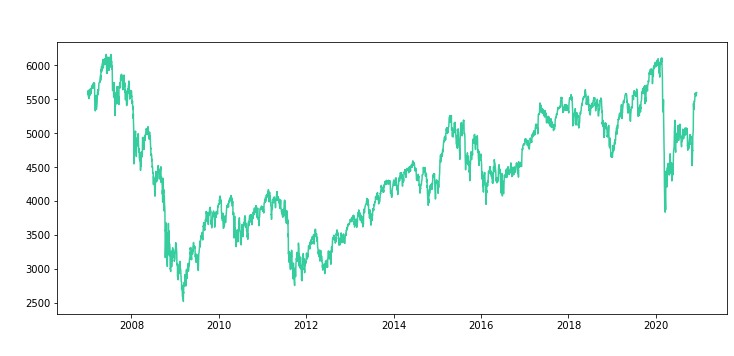



################################################################################




###################################   ^IBEX   ###################################

. Period: from 2007-01-02 to 2020-12-07
. Trading sessions: 3557
. Data:



,close,open,high,volume,low
date,,,,,
2007-01-02,14364.400391,14173.200195,14381.099609,184400.0,14157.299805
2007-01-03,14375.099609,14383.200195,14396.599609,199400.0,14307.700195
2007-01-04,14382.400391,14299.000000,14382.400391,214600.0,14231.200195
2007-01-05,14304.700195,14290.799805,14390.500000,227600.0,14286.099609
2007-01-08,14322.299805,14312.799805,14380.599609,214400.0,14290.299805
...,...,...,...,...,...
2020-12-01,8140.799805,8112.700195,8176.399902,284946100.0,8100.200195
2020-12-02,8220.799805,8111.100098,8226.200195,310837500.0,8104.200195
2020-12-03,8200.700195,8208.099609,8223.400391,233469300.0,8154.799805



. Statistics:



,close,open,high,volume,low
count,3557.000000,3557.000000,3557.000000,3.557000e+03,3557.000000
mean,9964.784518,9970.022974,10047.342767,1.725799e+08,9876.625558
std,1961.967033,1961.593976,1964.901602,1.301598e+08,1957.436525
min,5956.299805,5950.399902,6093.100098,0.000000e+00,5814.500000
25%,8686.099609,8685.900391,8763.200195,3.942000e+05,8603.299805
50%,9725.400391,9735.099609,9797.400391,1.807052e+08,9650.500000
75%,10746.500000,10748.200195,10835.000000,2.555740e+08,10663.000000
max,15945.700195,15999.200195,16040.400391,9.752120e+08,15868.599609



. Plot:



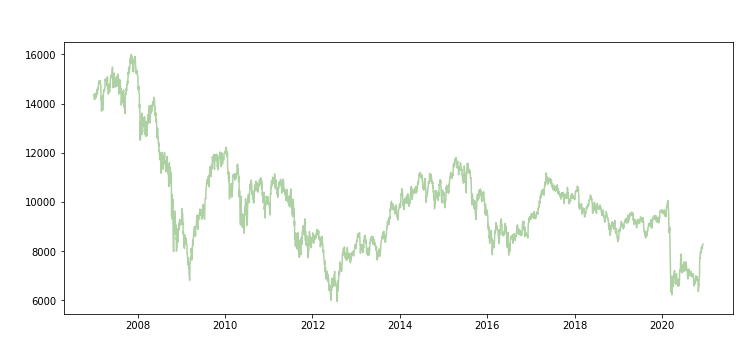



################################################################################




###################################   ^GSPTSE   ###################################

. Period: from 2007-01-02 to 2020-12-07
. Trading sessions: 3499
. Data:



,volume,open,low,close,high
date,,,,,
2007-01-02,60857400,12924.500000,12908.400391,12923.700195,12989.599609
2007-01-03,199791400,12919.200195,12672.799805,12701.400391,12926.400391
2007-01-04,247371600,12679.200195,12519.400391,12553.599609,12701.400391
2007-01-05,201713900,12517.599609,12439.299805,12478.000000,12553.599609
2007-01-08,172708200,12558.299805,12478.000000,12553.099609,12617.299805
...,...,...,...,...,...
2020-12-01,296753900,17431.300781,17285.300781,17296.900391,17471.199219
2020-12-02,261964200,17278.099609,17220.900391,17358.199219,17358.300781
2020-12-03,251025700,17386.000000,17382.000000,17398.000000,17452.900391



. Statistics:



,volume,open,low,close,high
count,3.499000e+03,3499.000000,3499.000000,3499.000000,3499.000000
mean,2.070628e+08,13757.149638,13674.732351,13753.688545,13825.890445
std,7.833546e+07,1936.528171,1958.717604,1937.410226,1918.981164
min,0.000000e+00,7527.399902,7480.000000,7566.899902,7695.299805
25%,1.685738e+08,12425.399902,12354.500000,12440.149902,12509.149902
50%,2.007466e+08,13807.500000,13718.599609,13797.000000,13877.400391
75%,2.359549e+08,15251.550293,15180.699707,15251.100098,15314.449707
max,9.440374e+08,17936.500000,17860.599609,17944.099609,17970.500000



. Plot:



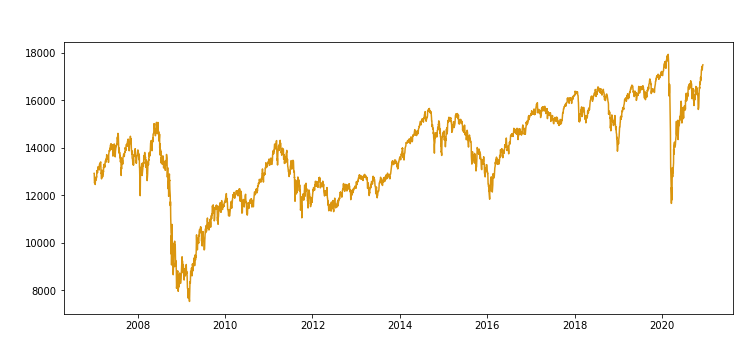



################################################################################




###################################   ^DJI   ###################################

. Period: from 2007-01-03 to 2020-12-07
. Trading sessions: 3508
. Data:



,close,open,high,volume,low
date,,,,,
2007-01-03,12474.519531,12459.540039,12580.349609,327200000,12404.820312
2007-01-04,12480.690430,12473.160156,12510.410156,259060000,12403.860352
2007-01-05,12398.009766,12480.049805,12480.129883,235220000,12365.410156
2007-01-08,12423.490234,12392.009766,12445.919922,223500000,12337.370117
2007-01-09,12416.599609,12424.769531,12466.429688,225190000,12369.169922
...,...,...,...,...,...
2020-12-01,29823.919922,29797.500000,30083.310547,429510000,29797.500000
2020-12-02,29883.789062,29695.089844,29902.509766,385280000,29599.289062
2020-12-03,29969.519531,29920.830078,30110.880859,405680000,29877.269531



. Statistics:



,close,open,high,volume,low
count,3508.000000,3508.000000,3508.000000,3.508000e+03,3508.000000
mean,16813.076871,16810.276410,16906.871683,2.226696e+08,16708.053692
std,5859.127776,5859.705774,5879.175834,1.305168e+08,5838.608275
min,6547.049805,6547.009766,6709.609863,8.410000e+06,6469.950195
25%,12284.937744,12284.360107,12380.577881,1.185300e+08,12210.927490
50%,15887.494629,15889.830078,16010.379883,2.029200e+08,15806.234863
75%,21151.557129,21132.205078,21235.201660,2.936650e+08,21019.822266
max,30218.259766,30233.029297,30233.029297,2.190810e+09,29989.560547



. Plot:



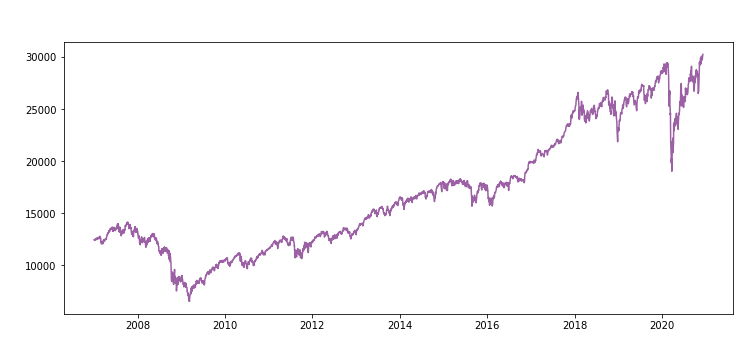



################################################################################




###################################   ^GSPC   ###################################

. Period: from 2007-01-03 to 2020-12-07
. Trading sessions: 3508
. Data:



,close,open,high,volume,low
date,,,,,
2007-01-03,1416.599976,1418.030029,1429.420044,3429160000,1407.859985
2007-01-04,1418.339966,1416.599976,1421.839966,3004460000,1408.430054
2007-01-05,1409.709961,1418.339966,1418.339966,2919400000,1405.750000
2007-01-08,1412.839966,1409.260010,1414.979980,2763340000,1403.969971
2007-01-09,1412.109985,1412.839966,1415.609985,3038380000,1405.420044
...,...,...,...,...,...
2020-12-01,3662.449951,3645.870117,3678.449951,5403660000,3645.870117
2020-12-02,3669.010010,3653.780029,3670.959961,5029620000,3644.840088
2020-12-03,3666.719971,3668.280029,3682.729980,5091760000,3657.169922



. Statistics:



,close,open,high,volume,low
count,3508.000000,3508.000000,3508.000000,3.508000e+03,3508.000000
mean,1883.547733,1883.267775,1893.805136,3.993587e+09,1871.747019
std,695.090407,695.057231,697.095831,1.155038e+09,692.771787
min,676.530029,679.280029,695.270020,1.025000e+09,666.789978
25%,1320.597504,1319.882538,1330.257538,3.282788e+09,1312.359985
50%,1797.600037,1796.704956,1802.649963,3.724025e+09,1788.179993
75%,2420.627441,2424.757507,2432.819946,4.426885e+09,2407.777466
max,3699.120117,3694.729980,3699.199951,1.145623e+10,3678.879883



. Plot:



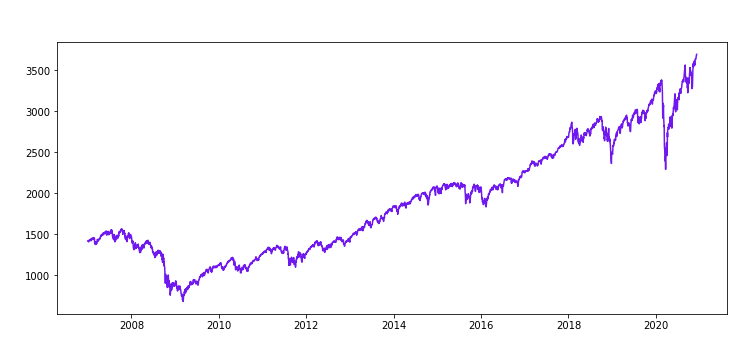



################################################################################


Total number of trading sessions: 55922


<IPython.core.display.Javascript object>

In [18]:
total_sessions = 0
for symbol, sdata in multi_data.stocks:
    print("\n\n" + "#"*35 + f"   {symbol}   " + "#"*35 + "\n\n" +
          f". Period: from {sdata.raw.index[0]} to {sdata.raw.index[-1]}\n" +
          f". Trading sessions: {len(sdata.raw)}\n"
          f". Data:\n")
    display(sdata.raw)
    total_sessions += len(sdata.raw)

    print(f"\n. Statistics:\n")
    display(sdata.raw.describe())

    print(f"\n. Plot:\n")
    ax = sdata.raw["open"].plot(figsize=(12,5), color=np.random.rand(1, 3))
    ax.set_title(f"{symbol} opening prices\n", fontsize=16, color="#ffffff");
    ax.set_ylabel("Opening prices", fontsize="14", color="#ffffff");
    ax.set_xlabel("Date", fontsize="14", color="#ffffff");
    plt.show()
    print("\n\n" + "#"*80 + "\n\n")

print(f"Total number of trading sessions: {total_sessions}")
Javascript("google.colab.output.setIframeHeight('400px');")

In [20]:
# data division dates
for symbol, data in multi_data.stocks:
    print(f">>>>> {symbol}")
    print(". Training range: %s to %s" % (
        data.raw_train["features"].index[0], data.raw_train["features"].index[-1]))
    print(". Validation range: %s to %s" % (
        data.raw_val["features"].index[0], data.raw_val["features"].index[-1]))
    print(". Test range: %s to %s\n" % (
        data.raw_test["features"].index[0], data.raw_test["features"].index[-1]))
Javascript("google.colab.output.setIframeHeight('200px');")

>>>>> ^IXIC
. Training range: 2007-01-03 to 2018-02-08
. Validation range: 2018-02-09 to 2019-10-10
. Test range: 2019-10-11 to 2020-11-20

>>>>> ^FTSE
. Training range: 2007-01-02 to 2018-02-13
. Validation range: 2018-02-14 to 2019-10-14
. Test range: 2019-10-15 to 2020-11-23

>>>>> 000001.SS
. Training range: 2007-01-04 to 2018-01-30
. Validation range: 2018-01-31 to 2019-10-10
. Test range: 2019-10-11 to 2020-11-23

>>>>> ^N225
. Training range: 2007-01-04 to 2018-02-05
. Validation range: 2018-02-06 to 2019-10-07
. Test range: 2019-10-08 to 2020-11-24

>>>>> ^MXX
. Training range: 2007-01-02 to 2018-02-12
. Validation range: 2018-02-13 to 2019-10-10
. Test range: 2019-10-11 to 2020-11-23

>>>>> ^GDAXI
. Training range: 2007-01-02 to 2018-02-05
. Validation range: 2018-02-06 to 2019-10-10
. Test range: 2019-10-11 to 2020-11-23

>>>>> ^HSI
. Training range: 2007-01-02 to 2018-02-07
. Validation range: 2018-02-08 to 2019-10-14
. Test range: 2019-10-15 to 2020-11-23

>>>>> ^AEX
. Trai

<IPython.core.display.Javascript object>

In [21]:
# comparing normalized values of the training sets
print("#"*20 + " Normalized training data " + "#"*20)
for symbol, data in multi_data.stocks:
    print(f"\n>>>>> {symbol}")
    display(data.norm_train["features"].tail())

Javascript("google.colab.output.setIframeHeight('300px');")

#################### Normalized training data ####################

>>>>> ^IXIC


,high,volume,close,open,low
date,,,,,
2018-02-02,0.977165,0.546225,0.957541,0.977921,0.964884
2018-02-05,0.963098,0.666050,0.913704,0.948624,0.921160
2018-02-06,0.938733,0.671626,0.937489,0.895653,0.898106
2018-02-07,0.945808,0.495258,0.927244,0.935759,0.934731
2018-02-08,0.930241,0.573909,0.883182,0.932710,0.890343



>>>>> ^FTSE


,close,volume,high,open,low
date,,,,,
2018-02-07,0.882995,0.260015,0.886206,0.850650,0.855440
2018-02-08,0.857518,0.245456,0.878613,0.882995,0.860065
2018-02-09,0.839166,0.232918,0.852902,0.857518,0.839543
2018-02-12,0.859018,0.176470,0.859809,0.839166,0.844051
2018-02-13,0.856885,0.176537,0.860542,0.859018,0.861110



>>>>> 000001.SS


,low,volume,close,open,high
date,,,,,
2018-01-24,0.425566,0.295181,0.422489,0.429108,0.420334
2018-01-25,0.425777,0.283981,0.419944,0.429493,0.420786
2018-01-26,0.427185,0.259830,0.422184,0.425008,0.421563
2018-01-29,0.421717,0.275347,0.414174,0.431425,0.424315
2018-01-30,0.415864,0.217478,0.406194,0.419537,0.409797



>>>>> ^N225


,close,volume,high,open,low
date,,,,,
2018-01-30,0.951247,0.149194,0.967856,0.969470,0.959593
2018-01-31,0.939900,0.167675,0.955724,0.948664,0.951289
2018-02-01,0.962620,0.171035,0.962618,0.952828,0.958278
2018-02-02,0.950225,0.165659,0.955288,0.957856,0.953039
2018-02-05,0.915516,0.180780,0.931782,0.931973,0.925677



>>>>> ^MXX


,volume,low,close,open,high
date,,,,,
2018-02-06,0.137486,0.918895,0.930836,0.926068,0.940338
2018-02-07,0.105465,0.923795,0.921403,0.932528,0.934410
2018-02-08,0.143780,0.891620,0.889402,0.926973,0.921385
2018-02-09,0.103324,0.870494,0.887593,0.896562,0.894920
2018-02-12,0.077364,0.885298,0.888494,0.895175,0.897664



>>>>> ^GDAXI


,volume,low,close,open,high
date,,,,,
2018-01-30,0.209809,0.965162,0.963420,0.964327,0.970979
2018-01-31,0.202926,0.963897,0.962588,0.962992,0.966789
2018-02-01,0.225926,0.945006,0.943830,0.965456,0.970125
2018-02-02,0.263446,0.925899,0.921720,0.937117,0.935059
2018-02-05,0.207275,0.909822,0.911848,0.910167,0.914637



>>>>> ^HSI


,volume,open,low,close,high
date,,,,,
2018-02-01,0.282589,0.982635,0.988527,0.976871,0.979940
2018-02-02,0.262408,0.965445,0.974095,0.975050,0.967541
2018-02-05,0.319928,0.926968,0.946671,0.958944,0.949891
2018-02-06,0.564466,0.896001,0.895629,0.884422,0.898880
2018-02-07,0.471500,0.911765,0.882772,0.872125,0.907457



>>>>> ^AEX


,high,volume,close,open,low
date,,,,,
2018-02-01,0.975085,0.189456,0.962457,0.973943,0.964144
2018-02-02,0.954014,0.168354,0.944183,0.954340,0.948406
2018-02-05,0.925686,0.182144,0.924187,0.923194,0.923879
2018-02-06,0.894617,0.350033,0.879861,0.867277,0.874262
2018-02-07,0.905690,0.234351,0.907258,0.895504,0.893820



>>>>> ^BVSP


,close,open,low,volume,high
date,,,,,
2018-01-30,0.981300,0.985132,0.981425,0.015353,0.972302
2018-01-31,0.988983,0.981352,0.993700,0.018227,1.000000
2018-02-01,0.999358,0.988983,1.000000,0.017589,0.996620
2018-02-02,0.973438,0.999358,0.981913,0.014539,0.986882
2018-02-05,0.934576,0.973419,0.946352,0.014008,0.965249



>>>>> ^AXJO


,close,open,high,volume,low
date,,,,,
2018-02-08,0.745330,0.748299,0.739751,0.0,0.743142
2018-02-09,0.731022,0.752112,0.738963,0.0,0.729113
2018-02-12,0.726325,0.737658,0.725324,0.0,0.730343
2018-02-13,0.735882,0.732913,0.730676,0.0,0.736797
2018-02-14,0.731891,0.742567,0.732823,0.0,0.741146



>>>>> ^NYA


,high,volume,open,low,close
date,,,,,
2018-02-02,0.963214,0.375440,0.968136,0.950486,0.941378
2018-02-05,0.937000,0.461187,0.933955,0.890890,0.886928
2018-02-06,0.907907,0.514276,0.871247,0.871606,0.905260
2018-02-07,0.917293,0.403848,0.904356,0.908760,0.899068
2018-02-08,0.899612,0.463105,0.904882,0.864434,0.854807



>>>>> ^FCHI


,volume,low,close,open,high
date,,,,,
2018-02-01,0.163815,0.813619,0.804432,0.822222,0.823313
2018-02-02,0.186942,0.795080,0.779885,0.801124,0.797826
2018-02-05,0.182047,0.772674,0.758193,0.770640,0.768923
2018-02-06,0.330088,0.722735,0.724204,0.710533,0.739425
2018-02-07,0.221657,0.741449,0.749990,0.739075,0.750974



>>>>> ^IBEX


,close,open,high,volume,low
date,,,,,
2018-02-02,0.425942,0.438749,0.429875,0.258002,0.431584
2018-02-05,0.411256,0.416766,0.410232,0.247010,0.416850
2018-02-06,0.385779,0.382583,0.389472,0.396835,0.383026
2018-02-07,0.402487,0.398097,0.391604,0.296906,0.392079
2018-02-08,0.380403,0.395878,0.388719,0.289406,0.383528



>>>>> ^GSPTSE


,volume,open,low,close,high
date,,,,,
2018-02-02,0.271573,0.931711,0.916074,0.908784,0.926840
2018-02-05,0.308053,0.898927,0.880371,0.878126,0.904046
2018-02-06,0.336730,0.856277,0.842175,0.881415,0.883155
2018-02-07,0.283325,0.884850,0.885030,0.877651,0.885378
2018-02-08,0.298566,0.881429,0.855689,0.847694,0.878308



>>>>> ^DJI


,close,open,high,volume,low
date,,,,,
2018-02-02,0.945403,0.973924,0.972124,0.630841,0.952684
2018-02-05,0.886846,0.937795,0.944935,0.865744,0.874209
2018-02-06,0.915099,0.875277,0.916086,1.000000,0.866940
2018-02-07,0.914131,0.915587,0.933554,0.608451,0.917362
2018-02-08,0.862666,0.916057,0.913949,0.795912,0.870470



>>>>> ^GSPC


,close,open,high,volume,low
date,,,,,
2018-02-02,0.949580,0.973349,0.970633,0.314069,0.958113
2018-02-05,0.898044,0.942334,0.949724,0.408241,0.902361
2018-02-06,0.919079,0.884618,0.921092,0.466547,0.881718
2018-02-07,0.912941,0.919431,0.933321,0.345268,0.922117
2018-02-08,0.867111,0.916717,0.913850,0.410349,0.875992


<IPython.core.display.Javascript object>

In [22]:
# comparing normalized values of the validation sets
print("#"*20 + " Normalized validation data " + "#"*20)
for symbol, data in multi_data.stocks:
    print(f"\n>>>>> {symbol}")
    display(data.norm_val["features"].tail())

Javascript("google.colab.output.setIframeHeight('300px');")

#################### Normalized validation data ####################

>>>>> ^IXIC


,high,volume,close,open,low
date,,,,,
2019-10-04,1.077687,0.349815,1.076429,1.068386,1.071702
2019-10-07,1.081999,0.350406,1.072232,1.076124,1.078599
2019-10-08,1.067227,0.395218,1.050987,1.066746,1.059480
2019-10-09,1.068688,0.307576,1.063807,1.066373,1.067523
2019-10-10,1.077076,0.359476,1.071348,1.067760,1.071770



>>>>> ^FTSE


,close,volume,high,open,low
date,,,,,
2019-10-08,0.851072,0.169466,0.865486,0.863893,0.855858
2019-10-09,0.856533,0.139465,0.858981,0.851072,0.855091
2019-10-10,0.861198,0.171403,0.862884,0.856533,0.852906
2019-10-11,0.875425,0.390015,0.871683,0.861198,0.856207
2019-10-14,0.867549,0.193208,0.872085,0.875425,0.867711



>>>>> 000001.SS


,low,volume,close,open,high
date,,,,,
2019-09-27,0.287035,0.155058,0.279445,0.286841,0.277285
2019-09-30,0.283438,0.136040,0.273293,0.286483,0.276695
2019-10-08,0.283568,0.146424,0.275204,0.281431,0.275910
2019-10-09,0.280319,0.152141,0.277779,0.280592,0.274058
2019-10-10,0.286418,0.156574,0.282989,0.285523,0.279590



>>>>> ^N225


,close,volume,high,open,low
date,,,,,
2019-10-01,0.868833,0.104671,0.871359,0.867944,0.875598
2019-10-02,0.862586,0.106351,0.862917,0.862842,0.870472
2019-10-03,0.836992,0.113743,0.841936,0.843899,0.844005
2019-10-04,0.841003,0.096942,0.840319,0.837668,0.843925
2019-10-07,0.838955,0.079637,0.844141,0.845280,0.847013



>>>>> ^MXX


,volume,low,close,open,high
date,,,,,
2019-10-04,0.071358,0.740402,0.761748,0.736978,0.759213
2019-10-07,0.057953,0.754001,0.748406,0.764182,0.757920
2019-10-08,0.088980,0.742188,0.736427,0.750147,0.744519
2019-10-09,0.077366,0.740948,0.735473,0.740850,0.740658
2019-10-10,0.126612,0.741922,0.747759,0.739472,0.746531



>>>>> ^GDAXI


,volume,low,close,open,high
date,,,,,
2019-10-04,0.153457,0.834944,0.843651,0.836483,0.839850
2019-10-07,0.106486,0.844043,0.852204,0.841580,0.849169
2019-10-08,0.138321,0.840386,0.839344,0.850582,0.848447
2019-10-09,0.113157,0.842411,0.851884,0.838050,0.855280
2019-10-10,0.154090,0.850100,0.858954,0.849067,0.859039



>>>>> ^HSI


,volume,open,low,close,high
date,,,,,
2019-10-08,0.181558,0.662469,0.678879,0.672029,0.663980
2019-10-09,0.162090,0.657426,0.674161,0.662516,0.649572
2019-10-10,0.146363,0.652408,0.668099,0.663651,0.646938
2019-10-11,0.207261,0.668694,0.688536,0.690776,0.673778
2019-10-14,0.213922,0.692774,0.707002,0.700416,0.685000



>>>>> ^AEX


,high,volume,close,open,low
date,,,,,
2019-10-04,0.977907,0.129590,0.983233,0.967623,0.972907
2019-10-07,0.992206,0.106381,0.996717,0.977049,0.985358
2019-10-08,0.994517,0.119934,0.978201,0.993064,0.982526
2019-10-09,0.986024,0.140186,0.986355,0.973568,0.979213
2019-10-10,0.989894,0.158087,0.993406,0.983155,0.974564



>>>>> ^BVSP


,close,open,low,volume,high
date,,,,,
2019-10-02,1.276312,1.330130,1.290823,0.021812,1.325873
2019-10-03,1.284958,1.276327,1.270642,0.020087,1.280398
2019-10-04,1.303408,1.284973,1.292863,0.020018,1.299033
2019-10-07,1.268147,1.303336,1.283566,0.016956,1.298412
2019-10-08,1.257594,1.268019,1.271400,0.018697,1.275574



>>>>> ^AXJO


,close,open,high,volume,low
date,,,,,
2019-10-09,0.923436,0.941251,0.926318,0.000372,0.929714
2019-10-10,0.923545,0.931871,0.922297,0.000406,0.932176
2019-10-11,0.939753,0.936862,0.935637,0.000389,0.941748
2019-10-14,0.949473,0.952825,0.952373,0.000361,0.957664
2019-10-15,0.952025,0.956802,0.947265,0.000373,0.957500



>>>>> ^NYA


,high,volume,open,low,close
date,,,,,
2019-10-04,0.913925,0.261066,0.903606,0.909241,0.914409
2019-10-07,0.916205,0.256641,0.917092,0.917666,0.908691
2019-10-08,0.903119,0.292980,0.908370,0.898542,0.888838
2019-10-09,0.902668,0.238021,0.896405,0.902033,0.899491
2019-10-10,0.910442,0.280830,0.903462,0.908414,0.907444



>>>>> ^FCHI


,volume,low,close,open,high
date,,,,,
2019-10-04,0.143430,0.811812,0.813687,0.807444,0.811950
2019-10-07,0.114737,0.821571,0.822810,0.812925,0.821872
2019-10-08,0.136825,0.818865,0.804999,0.826460,0.823836
2019-10-09,0.130386,0.817573,0.816652,0.807809,0.819507
2019-10-10,0.164258,0.828585,0.835812,0.825078,0.837606



>>>>> ^IBEX


,close,open,high,volume,low
date,,,,,
2019-10-04,0.300869,0.297926,0.288390,0.188410,0.296418
2019-10-07,0.309108,0.298971,0.296885,0.166032,0.303624
2019-10-08,0.298697,0.310097,0.299418,0.177799,0.300653
2019-10-09,0.303882,0.298772,0.295809,0.131272,0.304006
2019-10-10,0.315144,0.303220,0.303509,0.197718,0.307629



>>>>> ^GSPTSE


,volume,open,low,close,high
date,,,,,
2019-10-04,0.213631,1.000169,1.001929,1.004126,1.003644
2019-10-07,0.181436,1.003985,1.005595,1.001006,1.006108
2019-10-08,0.231034,0.997866,0.992081,0.986559,0.994419
2019-10-09,0.196055,0.995699,0.995916,0.996270,0.998590
2019-10-10,0.216576,0.998871,1.001489,1.001108,1.002636



>>>>> ^DJI


,close,open,high,volume,low
date,,,,,
2019-10-04,0.997858,0.984400,0.998695,0.261057,0.991804
2019-10-07,0.993089,0.995910,1.001966,0.229041,0.999459
2019-10-08,0.977445,0.984644,0.990210,0.289603,0.985197
2019-10-09,0.986512,0.986223,0.990335,0.222739,0.990704
2019-10-10,0.994019,0.986678,0.999327,0.256606,0.993948



>>>>> ^GSPC


,close,open,high,volume,low
date,,,,,
2019-10-04,1.036033,1.023460,1.037137,0.188456,1.030705
2019-10-07,1.030014,1.035193,1.039897,0.183597,1.038541
2019-10-08,1.009193,1.024301,1.024155,0.223507,1.018849
2019-10-09,1.021185,1.020051,1.025923,0.163147,1.025601
2019-10-10,1.029713,1.023456,1.034712,0.210162,1.030046


<IPython.core.display.Javascript object>

In [23]:
# comparing normalized values of the test sets
print("#"*20 + " Normalized test data " + "#"*20)
for symbol, data in multi_data.stocks:
    print(f"\n>>>>> {symbol}")
    display(data.norm_test["features"].tail())

Javascript("google.colab.output.setIframeHeight('300px');")

#################### Normalized test data ####################

>>>>> ^IXIC


,high,volume,close,open,low
date,,,,,
2020-11-16,1.716029,0.904279,1.708396,1.703694,1.704252
2020-11-17,1.718042,0.900551,1.704422,1.714378,1.710313
2020-11-18,1.716800,1.033600,1.688751,1.711589,1.701840
2020-11-19,1.711976,1.177505,1.705283,1.692714,1.695543
2020-11-20,1.715666,1.176757,1.697308,1.711047,1.710329



>>>>> ^FTSE


,close,volume,high,open,low
date,,,,,
2020-11-17,0.668745,0.313566,0.676404,0.681870,0.661980
2020-11-18,0.673409,0.247114,0.669639,0.668745,0.666093
2020-11-19,0.661502,0.233387,0.667108,0.673409,0.663211
2020-11-20,0.665510,0.204179,0.667463,0.661502,0.665605
2020-11-23,0.661362,0.237362,0.668740,0.665510,0.665745



>>>>> 000001.SS


,low,volume,close,open,high
date,,,,,
2020-11-17,0.379137,0.330883,0.372421,0.382066,0.370007
2020-11-18,0.381432,0.335433,0.374109,0.379828,0.372547
2020-11-19,0.380623,0.295531,0.377708,0.380227,0.374462
2020-11-20,0.386533,0.304865,0.381047,0.384905,0.377370
2020-11-23,0.391487,0.436238,0.389430,0.390491,0.389056



>>>>> ^N225


,close,volume,high,open,low
date,,,,,
2020-11-17,1.110753,0.142473,1.113219,1.115430,1.114311
2020-11-18,1.093970,0.116263,1.102933,1.104683,1.102797
2020-11-19,1.088475,0.137769,1.089351,1.091062,1.092056
2020-11-20,1.082208,0.106519,1.083743,1.082724,1.089140
2020-11-24,1.119598,0.137265,1.125227,1.107086,1.117260



>>>>> ^MXX


,volume,low,close,open,high
date,,,,,
2020-11-17,0.161120,0.698098,0.719588,0.693398,0.718100
2020-11-18,0.120967,0.720919,0.728313,0.724976,0.736443
2020-11-19,0.113472,0.717033,0.717292,0.730591,0.724128
2020-11-20,0.068144,0.721830,0.718333,0.721904,0.721738
2020-11-23,0.070901,0.724560,0.728732,0.723186,0.728639



>>>>> ^GDAXI


,volume,low,close,open,high
date,,,,,
2020-11-17,0.112688,0.952925,0.956927,0.954889,0.954920
2020-11-18,0.110711,0.955369,0.963843,0.950434,0.961250
2020-11-19,0.111543,0.951324,0.952145,0.951977,0.953617
2020-11-20,0.115899,0.953351,0.957309,0.947223,0.957133
2020-11-23,0.112678,0.960636,0.956270,0.963465,0.971238



>>>>> ^HSI


,volume,open,low,close,high
date,,,,,
2020-11-17,0.244365,0.692511,0.704908,0.695594,0.680105
2020-11-18,0.233976,0.688866,0.705132,0.701430,0.684129
2020-11-19,0.246337,0.690055,0.703637,0.692968,0.676888
2020-11-20,0.219342,0.687632,0.703711,0.697240,0.681656
2020-11-23,0.228098,0.699034,0.706234,0.698806,0.686184



>>>>> ^AEX


,high,volume,close,open,low
date,,,,,
2020-11-17,1.077620,0.000210,1.081061,1.071825,1.073583
2020-11-18,1.083210,0.000192,1.080900,1.068584,1.075747
2020-11-19,1.067568,0.000191,1.067793,1.062264,1.066022
2020-11-20,1.077539,0.000164,1.082891,1.061434,1.069094
2020-11-23,1.092698,0.210825,1.082219,1.088107,1.085794



>>>>> ^BVSP


,close,open,low,volume,high
date,,,,,
2020-11-16,1.372558,1.342253,1.359147,0.050478,1.370983
2020-11-17,1.386801,1.372578,1.379328,0.044393,1.394588
2020-11-18,1.373503,1.387125,1.386007,0.044506,1.388321
2020-11-19,1.374109,1.366998,1.373876,0.036836,1.379296
2020-11-23,1.389475,1.365803,1.382992,0.041702,1.388833



>>>>> ^AXJO


,close,open,high,volume,low
date,,,,,
2020-11-18,0.919201,0.918733,0.915695,0.000609,0.922713
2020-11-19,0.923572,0.927756,0.917326,0.000518,0.923616
2020-11-20,0.921400,0.931295,0.921374,0.000470,0.933899
2020-11-23,0.927482,0.929978,0.930040,0.000410,0.934883
2020-11-24,0.949881,0.936122,0.948352,0.000599,0.941009



>>>>> ^NYA


,high,volume,open,low,close
date,,,,,
2020-11-16,1.037411,0.461057,1.037729,1.036332,1.036679
2020-11-17,1.037822,0.418948,1.030749,1.029876,1.033162
2020-11-18,1.039461,0.460400,1.042023,1.028765,1.018238
2020-11-19,1.025146,0.379462,1.018440,1.018709,1.024038
2020-11-20,1.026455,0.368269,1.027793,1.028965,1.020188



>>>>> ^FCHI


,volume,low,close,open,high
date,,,,,
2020-11-17,0.000000,0.815996,0.812229,0.810594,0.811671
2020-11-18,0.000000,0.818974,0.820026,0.810561,0.820993
2020-11-19,0.000000,0.818242,0.809943,0.807771,0.812465
2020-11-20,0.000000,0.821516,0.815762,0.809412,0.821889
2020-11-23,0.180682,0.829951,0.814737,0.831359,0.830624



>>>>> ^IBEX


,close,open,high,volume,low
date,,,,,
2020-11-17,0.198010,0.201875,0.189589,0.543351,0.193761
2020-11-18,0.202735,0.195416,0.191127,0.375414,0.199071
2020-11-19,0.197599,0.194730,0.189569,0.331362,0.196581
2020-11-20,0.202375,0.197874,0.191811,0.294686,0.202212
2020-11-23,0.202705,0.206861,0.198466,0.352522,0.207451



>>>>> ^GSPTSE


,volume,open,low,close,high
date,,,,,
2020-11-17,0.307597,1.046828,1.047806,1.060502,1.060898
2020-11-18,0.296771,1.066257,1.060903,1.053911,1.065230
2020-11-19,0.260468,1.051095,1.052871,1.056172,1.057437
2020-11-20,0.267921,1.061413,1.061670,1.068528,1.071911
2020-11-23,0.322763,1.076981,1.077925,1.077052,1.082041



>>>>> ^DJI


,close,open,high,volume,low
date,,,,,
2020-11-16,1.166108,1.154117,1.168160,0.502593,1.162132
2020-11-17,1.157782,1.160494,1.163545,0.446299,1.154515
2020-11-18,1.140596,1.164250,1.166480,0.459137,1.150135
2020-11-19,1.142828,1.139073,1.146088,0.395963,1.139894
2020-11-20,1.131879,1.142399,1.143325,0.364107,1.140035



>>>>> ^GSPC


,close,open,high,volume,low
date,,,,,
2020-11-16,1.343317,1.334985,1.347006,0.408100,1.342694
2020-11-17,1.335403,1.339624,1.344526,0.361853,1.337439
2020-11-18,1.316399,1.340437,1.342680,0.407378,1.327667
2020-11-19,1.322810,1.316360,1.327126,0.318486,1.316915
2020-11-20,1.311732,1.325455,1.325294,0.306193,1.322870


<IPython.core.display.Javascript object>

In [24]:
# sample output shape
sample_x, sample_y = next(iter(multi_data.tf_datasets["train"]))
print(f"Sample input shape: {sample_x.shape}")
print(f"Sample label shape: {sample_y.shape}")

Sample input shape: (80, 10, 5)
Sample label shape: (80, 3)


## **2) Defining a model**

In [10]:
class MultiLSTM(tf.keras.Model):
    """ Custom LSTM model. """

    def __init__(self, num_sessions=NUM_SESSIONS):
        super(MultiLSTM, self).__init__()
        self._num_sessions = num_sessions

        self._open_predictor = model = tf.keras.models.Sequential([
            #tf.keras.layers.LSTM(256, return_sequences=True),
            #tf.keras.layers.Dropout(0.3),
            tf.keras.layers.LSTM(32, return_sequences=True),
            #tf.keras.layers.Dropout(0.3),
            tf.keras.layers.LSTM(32, return_sequences=False),
            #tf.keras.layers.Dropout(0.3),
            #tf.keras.layers.Dense(128, activation="tanh"),  
            #tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation="relu"),
        ])

        self._pre_lowest = tf.keras.layers.LSTM(32, return_sequences=True)
        self._lowest_predictor = tf.keras.models.Sequential([
            #tf.keras.layers.LSTM(256, return_sequences=True),
            #tf.keras.layers.Dropout(0.3),
            tf.keras.layers.LSTM(32, return_sequences=True),
            #tf.keras.layers.Dropout(0.3),
            tf.keras.layers.LSTM(32, return_sequences=False),
            #tf.keras.layers.Dropout(0.3),
            #tf.keras.layers.Dense(128, activation="tanh"),  
            #tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation="relu"),
        ])

        self._pre_highest = tf.keras.layers.LSTM(32, return_sequences=True)
        self._highest_predictor = tf.keras.models.Sequential([
            #tf.keras.layers.LSTM(256, return_sequences=True),
            #tf.keras.layers.Dropout(0.3),
            tf.keras.layers.LSTM(32, return_sequences=True),
            #tf.keras.layers.Dropout(0.3),
            tf.keras.layers.LSTM(32, return_sequences=False),
            #tf.keras.layers.Dropout(0.3),
            #tf.keras.layers.Dense(128, activation="tanh"),  
            #tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation="relu"),
        ])

    def call(self, inputs, training=None):
        # calculating the opening price
        open_price = self._open_predictor(inputs, training=training)

        # cloning prices: expanding shape from (batches, 1) to (batches, NUM_SESSIONS, 1)
        open_price_exp = tf.tile(tf.expand_dims(open_price, -1),   
                                 [1, self._num_sessions, 1])

        # calculating the lowest price
        lowest_price = self._lowest_predictor(
            # appends the opening price to the end of each item in the input sequence
            tf.concat([self._pre_lowest(inputs), open_price_exp], -1),
            training=training,
        )

        # cloning prices: expanding shape from (batches, 1) to (batches, NUM_SESSIONS, 1)
        lowest_price_exp = tf.tile(tf.expand_dims(lowest_price, -1),   
                                   [1, self._num_sessions, 1])

        # calculating the highest price
        highest_price = self._highest_predictor(
            # appends the opening price and the lowest price to the end of each item in the input sequence
            tf.concat(
                [self._pre_highest(inputs), open_price_exp, lowest_price_exp], -1),
            training=training,
        )

        # returning the concatenation of the opening price, lowest price and highest price
        return tf.concat([open_price, lowest_price, highest_price], -1)

In [11]:
# testing output shape
x, y = next(iter(multi_data.tf_datasets["train"]))
MultiLSTM()(x).shape

TensorShape([42, 3])

## **3) Training the model**

In [12]:
# loading all validation data into memory (so we dont have to use a generator)
val_inputs, val_outputs = [], []
for x, y in multi_data.tf_datasets["val"]:
    val_inputs.append(x)
    val_outputs.append(y)

val_inputs = tf.concat(val_inputs, axis=0)
val_outputs = tf.concat(val_outputs, axis=0)

print(val_inputs.shape, val_outputs.shape)

(2877, 10, 5) (2877, 3)



Epoch 00010: val_loss improved from 0.00080 to 0.00055, saving model to saved_model_2020-12-09-23-21-58/checkpoint_best


INFO:tensorflow:Assets written to: saved_model_2020-12-09-23-21-58/assets


INFO:tensorflow:Assets written to: saved_model_2020-12-09-23-21-58/assets


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

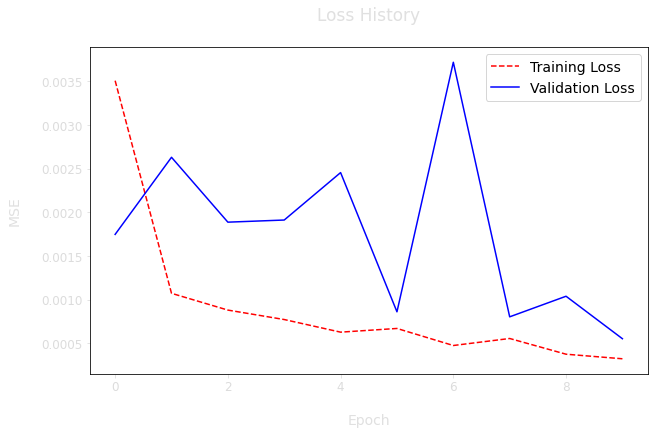

In [13]:
save_path = f"saved_model_{datetime.today().strftime('%Y-%m-%d-%H-%M-%S')}"

# building and compiling
model = MultiLSTM()
model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(learning_rate=1e-3),
              metrics=[])
                       #tf.metrics.MeanAbsoluteError()]) 
                       #tf.metrics.MeanAbsolutePercentageError()])

# training
epochs = 10
history = model.fit(
    multi_data.tf_datasets["train"].shuffle(buffer_size=multi_data.size["train"]), 
    epochs=epochs,
    validation_data=(val_inputs, val_outputs),
    callbacks=[ClearCallback(),
               ModelCheckpoint(filepath=os.path.join(save_path, "checkpoint_best"), 
                                                     monitor='val_loss', 
                                                     verbose=1, save_best_only=True)],
)

# restoring the checkpoint of the best model
model.load_weights(os.path.join(save_path, "checkpoint_best"))

# saving and downloading the model
model.save(save_path)
shutil.make_archive(save_path, "zip", save_path)
files.download(f"{save_path}.zip")

# visualizing loss history
print("\n\n")
plt.rc('xtick',labelsize=12, color="#DCDCDC")
plt.rc('ytick',labelsize=12, color="#DCDCDC")
plt.rcParams.update({'legend.fontsize': 14, 'legend.handlelength': 2})

plt.figure(figsize=(10, 6))
plt.plot(range(epochs), history.history["loss"], 'r--')
plt.plot(range(epochs), history.history["val_loss"], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])

plt.title("Loss History\n", fontsize=17, color="#E0E0E0")
plt.ylabel('MSE\n', fontsize=14, color="#E0E0E0")
plt.xlabel('\nEpoch', fontsize=14, color="#E0E0E0")
plt.show();

## **4) Evaluating on all the stocks**

In [57]:
loss = {}
for mode in ["train", "val", "test"]:
    loss[mode] = model.evaluate(multi_data.tf_datasets[mode])

loss = pd.Series(loss.values(), index=loss.keys())
print("\n\n>>> Loss value (on the normalized data):")
loss

47/47 [==============================] - 1s 25ms/step - loss: 0.0021


>>> Loss value (on the normalized data):


train    0.000313
val      0.000554
test     0.002135
dtype: float64

## **5) Evaluating on individual stocks**

In [58]:
results, predictions = {}, {}
for stk in STOCKS.keys():
    results[stk], predictions[stk] = {}, {}
    for mode in ["train", "val", "test"]:
        predictions[stk][mode], results[stk][mode] = eval(model, 
                                                          multi_data[stk], mode)

#### **5.1) Training data**

In [59]:
symbol = "^BVSP"

     Training Data

#########################

[> GENERAL <]
   . MAE:   897
   . MAPE:  1.6187%
   . MSE:   1440333

#########################

[> OPEN <]
   . MAE:   538
   . MAPE:  0.9735%
   . MSE:   497311
   . Tendency Accuracy:  72.9868%

#########################

[> LOW <]
   . MAE:   960
   . MAPE:  1.7691%
   . MSE:   1764929
   . Tendency Accuracy:  52.2328%

#########################

[> HIGH <]
   . MAE:   1194
   . MAPE:  2.1135%
   . MSE:   2058758
   . Tendency Accuracy:  49.3411%

#########################


<IPython.core.display.Javascript object>

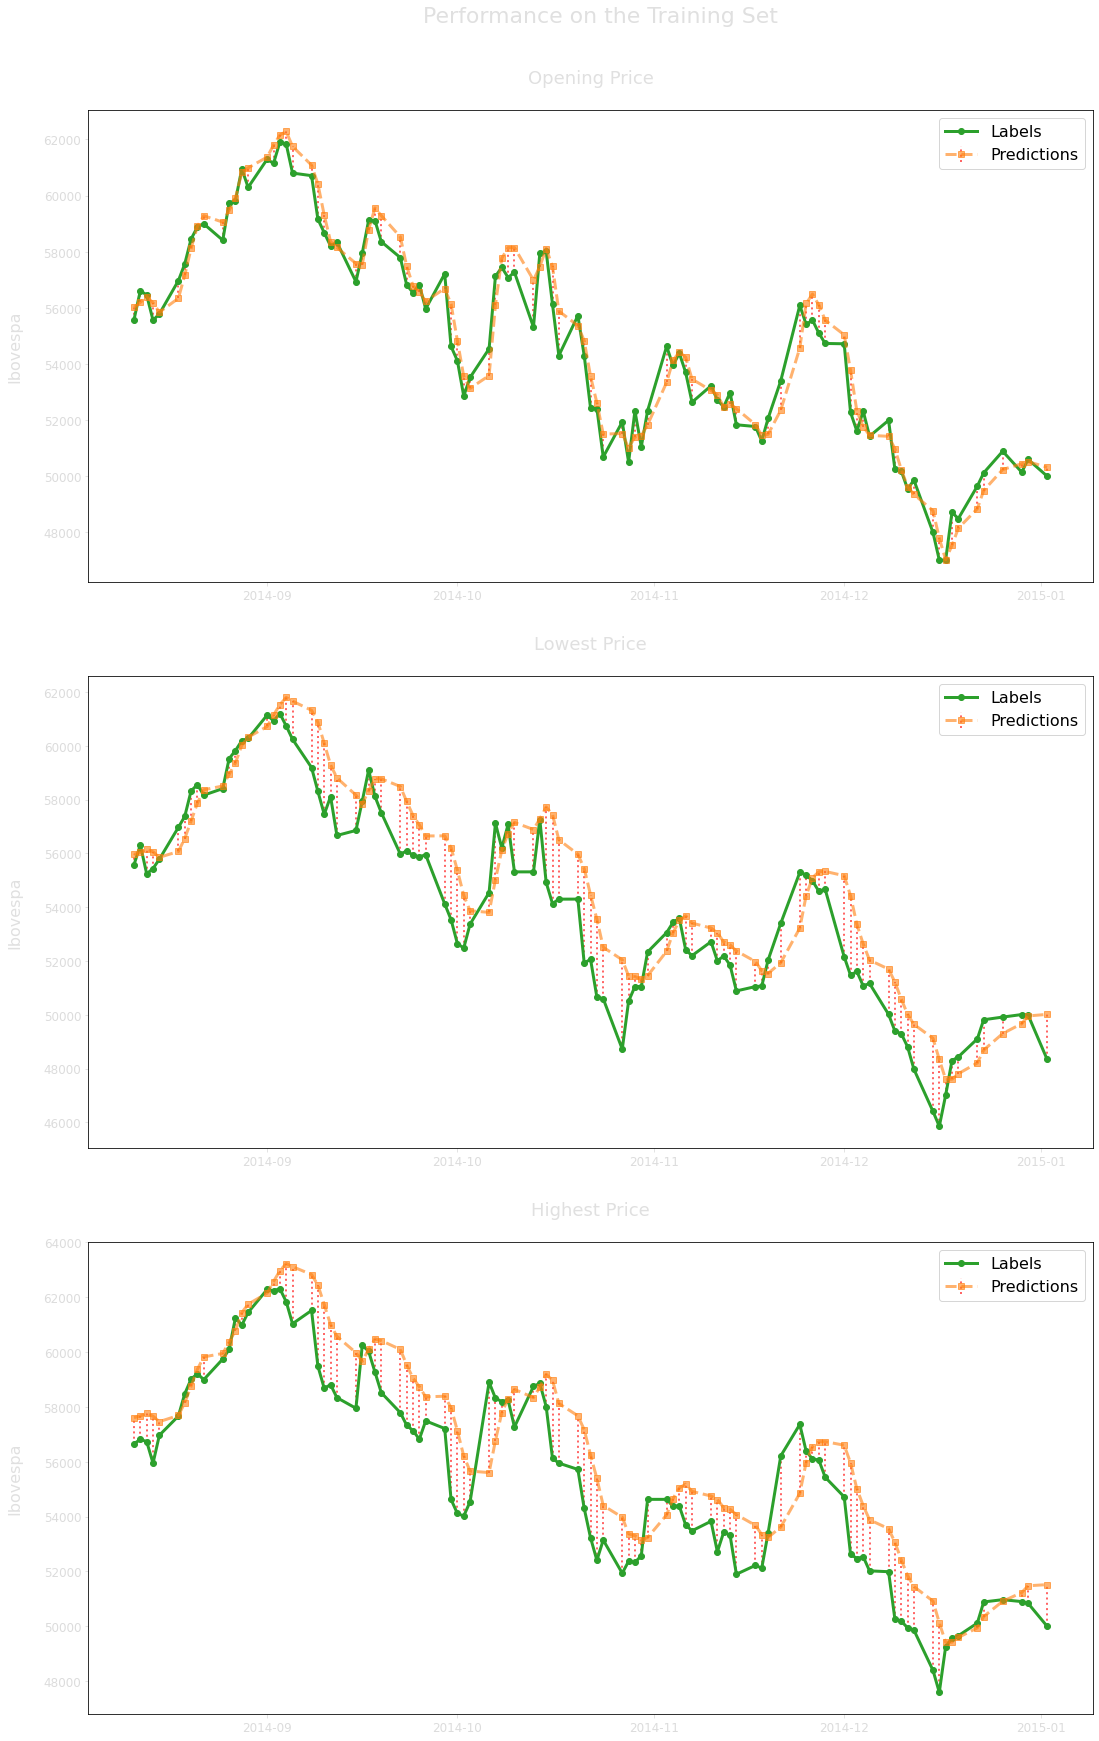

In [63]:
print("     Training Data\n")
eval_print(results[symbol]["train"])
eval_plot(predictions[symbol]["train"], 
          multi_data[symbol].raw_train["labels"], 
          start_date="random", 
          plot_samples=100, 
          title="Performance on the Training Set")

Javascript("google.colab.output.setIframeHeight('600px');")

#### **5.2) Validation data**

     Validation Data

#########################

[> GENERAL <]
   . MAE:   1356
   . MAPE:  1.5203%
   . MSE:   2608025

#########################

[> OPEN <]
   . MAE:   1191
   . MAPE:  1.3433%
   . MSE:   1704238
   . Tendency Accuracy:  54.7264%

#########################

[> LOW <]
   . MAE:   1468
   . MAPE:  1.6559%
   . MSE:   3237944
   . Tendency Accuracy:  49.7512%

#########################

[> HIGH <]
   . MAE:   1410
   . MAPE:  1.5617%
   . MSE:   2881894
   . Tendency Accuracy:  46.7662%

#########################


<IPython.core.display.Javascript object>

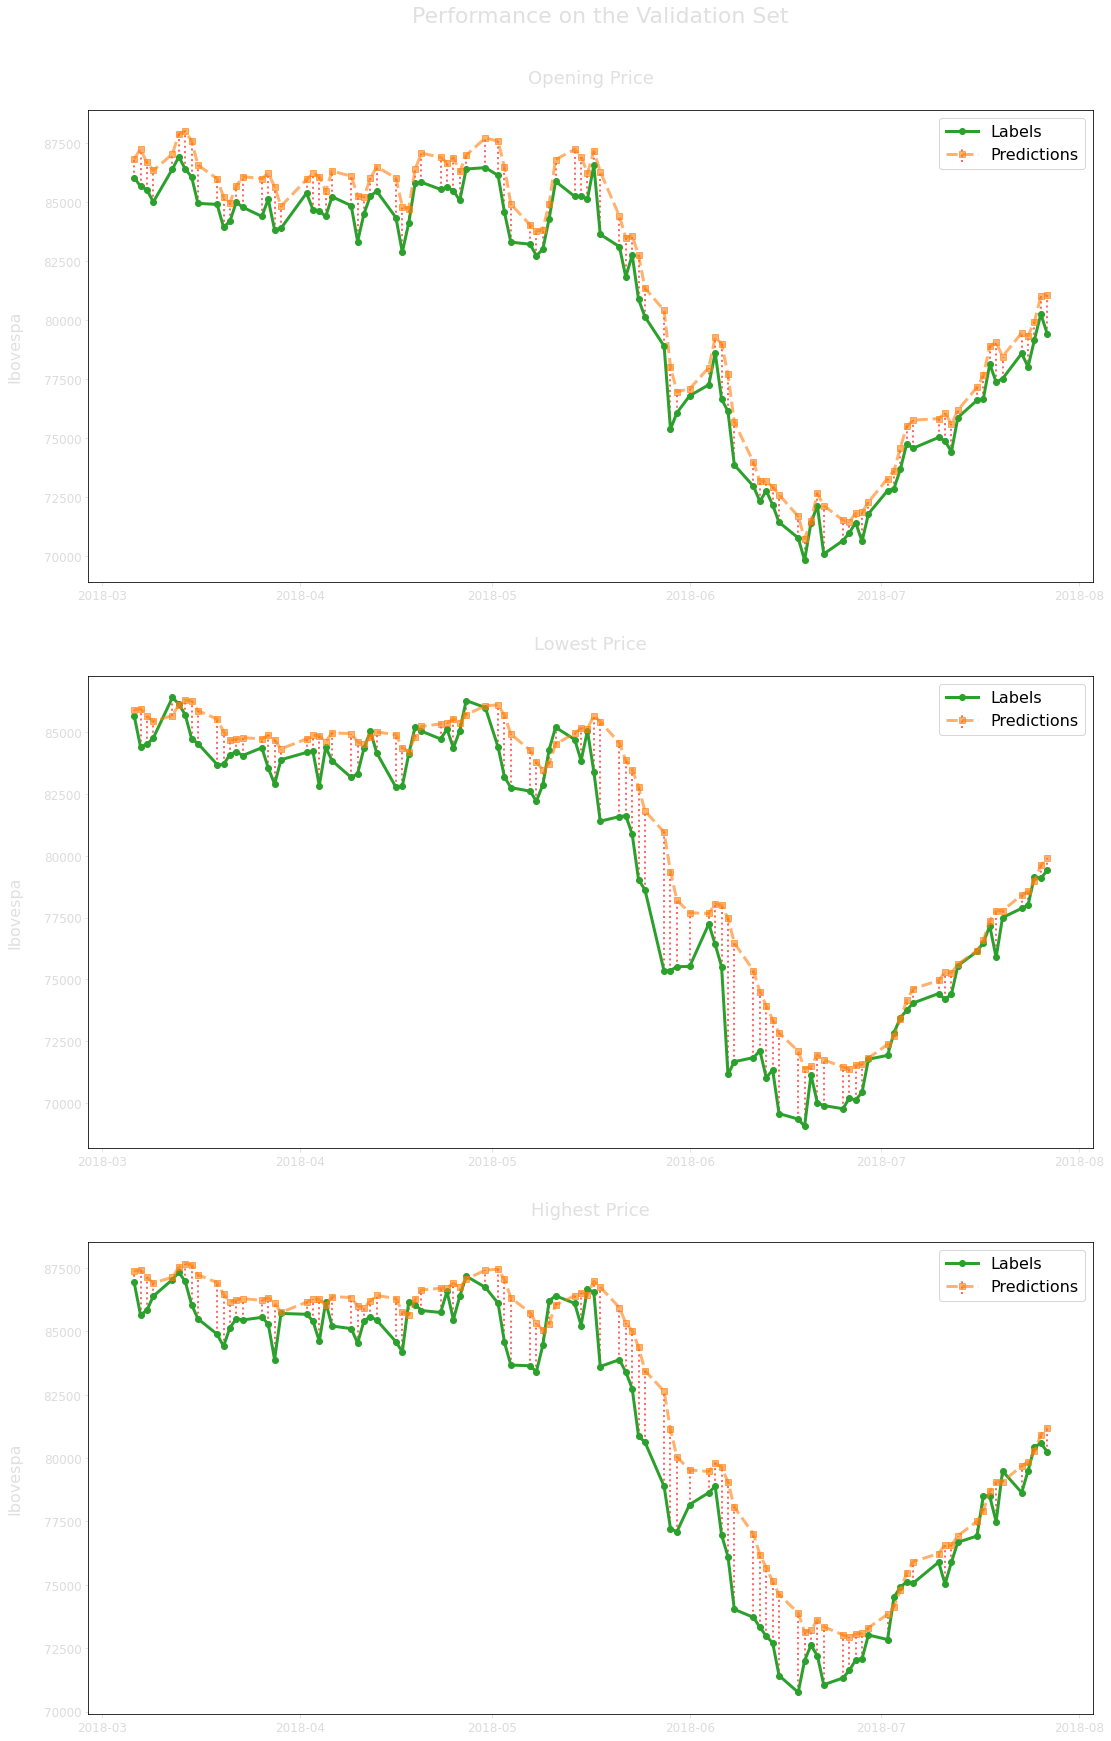

In [65]:
print("     Validation Data\n")
eval_print(results[symbol]["val"])
eval_plot(predictions[symbol]["val"], 
          multi_data[symbol].raw_val["labels"], 
          start_date="random", 
          plot_samples=100, 
          title="Performance on the Validation Set")

Javascript("google.colab.output.setIframeHeight('600px');")

#### **5.3) Test data**

    Test Data

#########################

[> GENERAL <]
   . MAE:   2612
   . MAPE:  2.6702%
   . MSE:   12944996

#########################

[> OPEN <]
   . MAE:   1252
   . MAPE:  1.3656%
   . MSE:   2987342
   . Tendency Accuracy:  66.6667%

#########################

[> LOW <]
   . MAE:   3420
   . MAPE:  3.5774%
   . MSE:   21049643
   . Tendency Accuracy:  49.0637%

#########################

[> HIGH <]
   . MAE:   3164
   . MAPE:  3.0675%
   . MSE:   14798003
   . Tendency Accuracy:  47.9401%

#########################


<IPython.core.display.Javascript object>

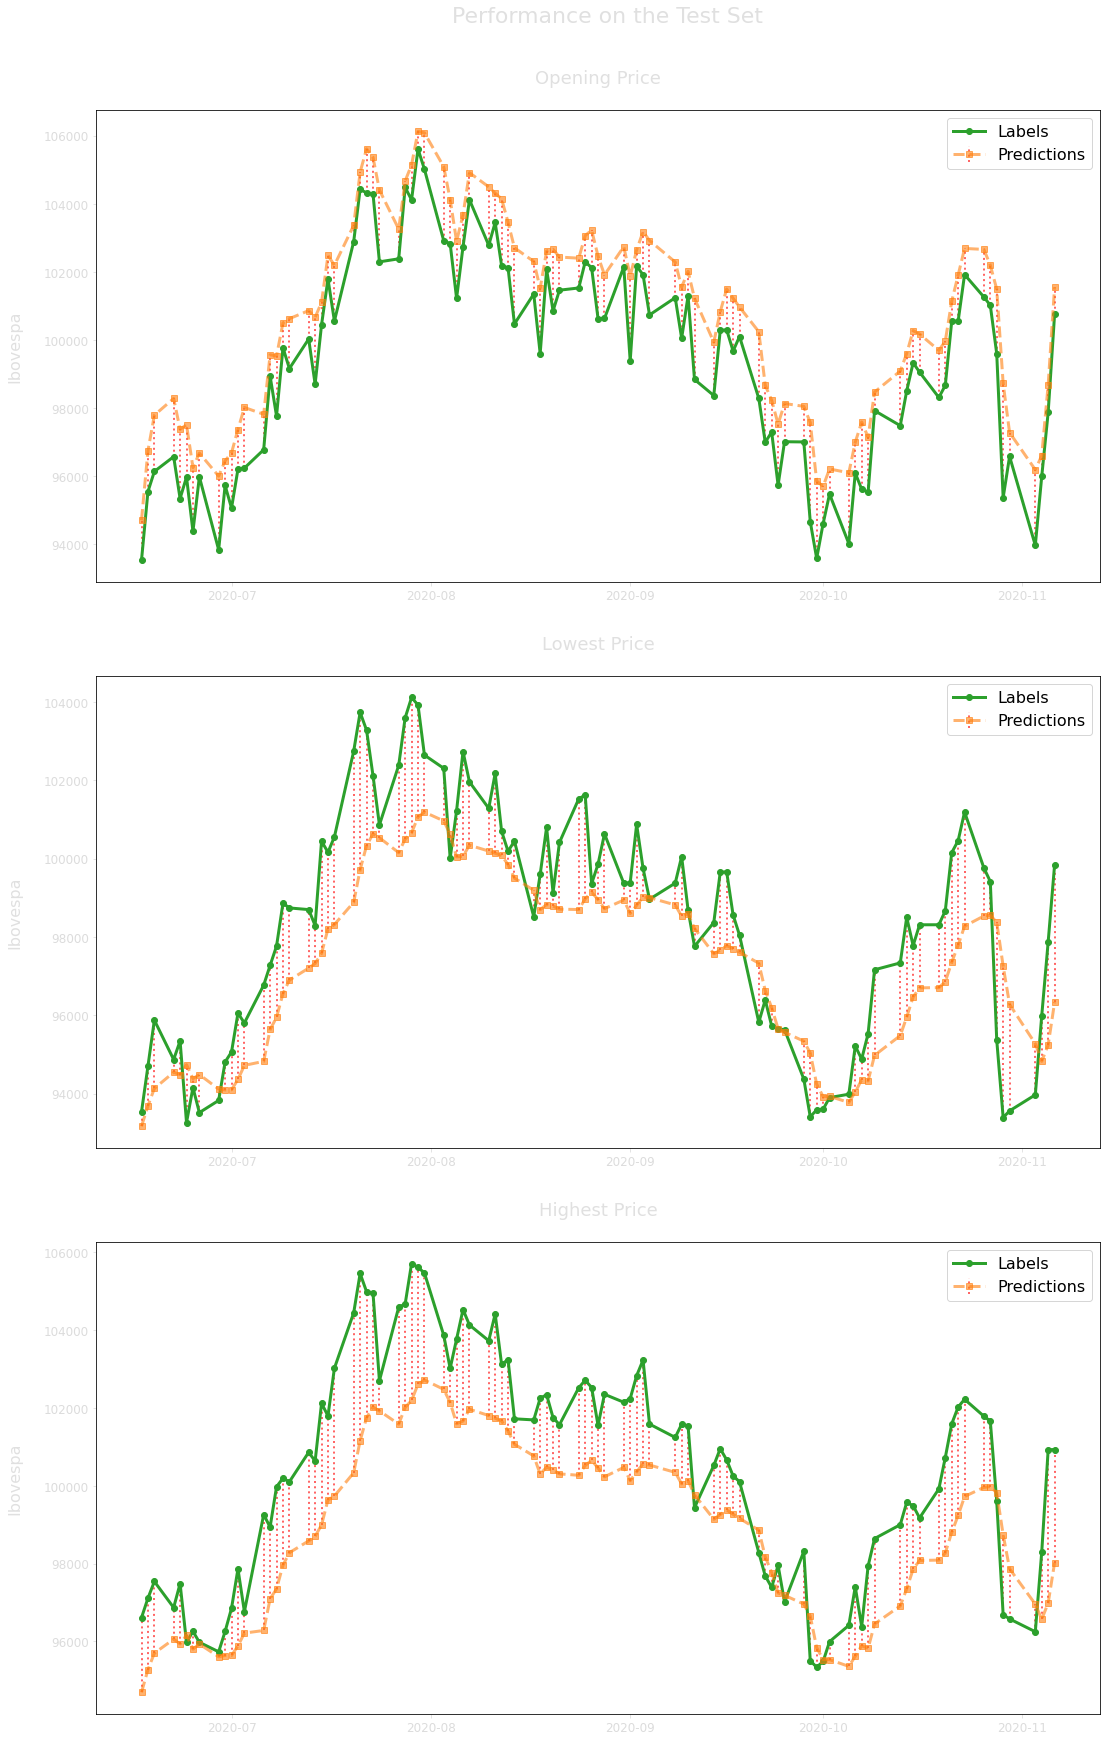

In [66]:
print("    Test Data\n")
eval_print(results[symbol]["test"])
eval_plot(predictions[symbol]["test"], 
          multi_data[symbol].raw_test["labels"], 
          start_date="random", 
          plot_samples=100, 
          title="Performance on the Test Set")

Javascript("google.colab.output.setIframeHeight('600px');")